In [2]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2
from tqdm import tqdm
from glob import glob
from PIL import Image
from skimage.transform import resize
from sklearn.model_selection import train_test_split, KFold

import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
tf.__version__

'2.3.0'

## Building the training dataset.
Let's look at the train image list

In [4]:
path = "../input/ultrasound-nerve-segmentation/train/"
file_list = os.listdir(path)
file_list[:20]

['11_8_mask.tif',
 '10_115_mask.tif',
 '28_42_mask.tif',
 '2_12.tif',
 '25_44.tif',
 '44_52.tif',
 '9_98_mask.tif',
 '45_75_mask.tif',
 '17_38.tif',
 '31_117.tif',
 '42_36_mask.tif',
 '39_86_mask.tif',
 '23_34.tif',
 '24_81_mask.tif',
 '15_22_mask.tif',
 '35_32.tif',
 '24_110_mask.tif',
 '37_35_mask.tif',
 '5_42.tif',
 '29_100_mask.tif']

**Sort the file list in ascending order and seperate it into images and masks**<br/>


In [5]:
train_image = []
train_mask = glob(path + '*_mask*')

for i in train_mask:
    train_image.append(i.replace('_mask', ''))
        
print(train_image[:10],"\n" ,train_mask[:10])

['../input/ultrasound-nerve-segmentation/train/11_8.tif', '../input/ultrasound-nerve-segmentation/train/10_115.tif', '../input/ultrasound-nerve-segmentation/train/28_42.tif', '../input/ultrasound-nerve-segmentation/train/9_98.tif', '../input/ultrasound-nerve-segmentation/train/45_75.tif', '../input/ultrasound-nerve-segmentation/train/42_36.tif', '../input/ultrasound-nerve-segmentation/train/39_86.tif', '../input/ultrasound-nerve-segmentation/train/24_81.tif', '../input/ultrasound-nerve-segmentation/train/15_22.tif', '../input/ultrasound-nerve-segmentation/train/24_110.tif'] 
 ['../input/ultrasound-nerve-segmentation/train/11_8_mask.tif', '../input/ultrasound-nerve-segmentation/train/10_115_mask.tif', '../input/ultrasound-nerve-segmentation/train/28_42_mask.tif', '../input/ultrasound-nerve-segmentation/train/9_98_mask.tif', '../input/ultrasound-nerve-segmentation/train/45_75_mask.tif', '../input/ultrasound-nerve-segmentation/train/42_36_mask.tif', '../input/ultrasound-nerve-segmentation

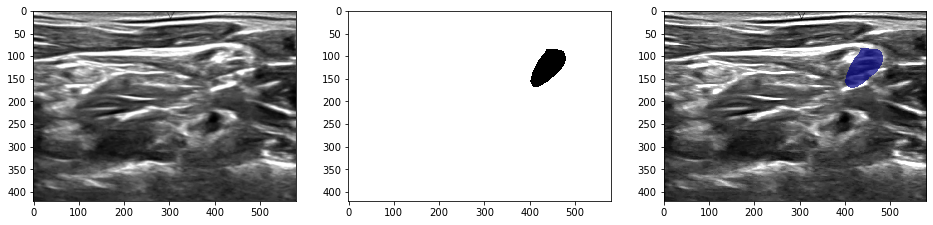

In [6]:
# Display the first image and mask of the first subject.
image1 = np.array(Image.open(path+"1_1.tif"))
image1_mask = np.array(Image.open(path+"1_1_mask.tif"))
image1_mask = np.ma.masked_where(image1_mask == 0, image1_mask)

fig, ax = plt.subplots(1,3,figsize = (16,12))
ax[0].imshow(image1, cmap = 'gray')

ax[1].imshow(image1_mask, cmap = 'gray')

ax[2].imshow(image1, cmap = 'gray', interpolation = 'none')
ax[2].imshow(image1_mask, cmap = 'jet', interpolation = 'none', alpha = 0.7)

Now, I try to load all image files and store them variables X and y.<br/>


## How to deal with train_masks.csv ?

In [7]:
width = 128
height = 128

Let's modularize this work.

In [8]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import Input
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [9]:
def dice_coef(y_true, y_pred, smooth = 1.):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred, smooth = 1.):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true) + K.sum(y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def sensitivity(y_true, y_pred):
    s = K.sum(y_true, axis=(1,2,3))
    y_true_c = s / (s + K.epsilon())
    s_ = K.sum(y_pred, axis=(1,2,3))
    y_pred_c = s_ / (s_ + K.epsilon())
   
    true_positives = K.sum(K.round(K.clip(y_true_c * y_pred_c, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true_c, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    s = K.sum(y_true, axis=(1,2,3))
    y_true_c = s / (s + K.epsilon())
    s_ = K.sum(y_pred, axis=(1,2,3))
    y_pred_c = s_ / (s_ + K.epsilon())
    
    true_negatives = K.sum(K.round(K.clip((1-y_true_c) * (1-y_pred_c), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true_c, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [10]:
def unet(input_size=(128, 128, 3)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [11]:
def train_generator(data_frame, batch_size, train_path, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):
   
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        directory = train_path,
        x_col = "filename",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        directory = train_path,
        x_col = "mask",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

In [12]:
pos_mask = []
pos_img = []
neg_mask = []
neg_img = []

for mask_path, img_path in zip(train_mask, train_image):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if np.sum(mask) == 0:
        neg_mask.append(mask_path)
        neg_img.append(img_path)
    else:
        pos_mask.append(mask_path)
        pos_img.append(img_path)

In [13]:
!mkdir generated
!mkdir generated/img

In [14]:
def flip_up_down(img):
    newImg = img.copy()
    return cv2.flip(newImg, 0)

def flip_right_left(img):
    newImg = img.copy()
    return cv2.flip(newImg, 1)

In [15]:
gen_img = []
gen_mask = []

for (img_path, mask_path) in tqdm(zip(pos_img, pos_mask)):
    image_name = img_path.split('/')[-1].split('.')[0]

    uf_img_path = 'generated/img/'+image_name+'_uf.jpg'
    uf_mask_path = 'generated/img/'+image_name+'_uf_mask.jpg'
    rf_img_path = 'generated/img/'+image_name+'_rf.jpg'
    rf_mask_path = 'generated/img/'+image_name+'_rf_mask.jpg'

    img = cv2.imread(img_path)
    mask = cv2.imread(mask_path)

    uf_img = flip_up_down(img)
    uf_mask = flip_up_down(mask)
    rf_img = flip_right_left(img)
    rf_mask = flip_right_left(mask)

    cv2.imwrite(uf_img_path, uf_img)
    cv2.imwrite(uf_mask_path, uf_mask)
    cv2.imwrite(rf_img_path, rf_img)
    cv2.imwrite(rf_mask_path, rf_mask)
    
    gen_img.append(uf_img_path)
    gen_mask.append(uf_mask_path)
    gen_img.append(rf_img_path)
    gen_mask.append(rf_mask_path)

2323it [01:11, 32.51it/s]


In [16]:
aug_img = gen_img + train_image
aug_mask = gen_mask + train_mask

df_ = pd.DataFrame(data={"filename": aug_img, 'mask' : aug_mask})
df = df_.sample(frac=1).reset_index(drop=True)

kf = KFold(n_splits = 5, shuffle=False)

In [17]:
histories = []
losses = []
accuracies = []
dicecoefs = []
ious = []

train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

EPOCHS = 120
BATCH_SIZE = 32

for k, (train_index, test_index) in enumerate(kf.split(df)):
    train_data_frame = df.iloc[train_index]
    test_data_frame = df.iloc[test_index]
    
    train_gen = train_generator(train_data_frame, BATCH_SIZE,
                                None,
                                train_generator_args,
                                target_size=(height, width))

    test_gener = train_generator(test_data_frame, BATCH_SIZE,
                                None,
                                dict(),
                                target_size=(height, width))

    model = unet(input_size=(height,width, 3))
    model.compile(optimizer=Adam(lr=5e-6), loss=dice_coef_loss, \
                      metrics=[iou, dice_coef, sensitivity, specificity, 'binary_accuracy'])

    model_checkpoint = ModelCheckpoint(str(k+1) + '_unet_ner_seg.hdf5', 
                                       verbose=1, 
                                       save_best_only=True)

    history = model.fit(train_gen,
                                  steps_per_epoch=len(train_data_frame) // BATCH_SIZE, 
                                  epochs=EPOCHS, 
                                  callbacks=[model_checkpoint],
                                  validation_data = test_gener,
                                  validation_steps=len(test_data_frame) // BATCH_SIZE)
    
    model = load_model(str(k+1) + '_unet_ner_seg.hdf5', custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef, 'sensitivity': sensitivity, 'specificity': specificity})
    
    test_gen = train_generator(test_data_frame, BATCH_SIZE,
                                None,
                                dict(),
                                target_size=(height, width))
    results = model.evaluate(test_gen, steps=len(test_data_frame) // BATCH_SIZE)
    results = dict(zip(model.metrics_names,results))
    
    histories.append(history)
    accuracies.append(results['binary_accuracy'])
    losses.append(results['loss'])
    dicecoefs.append(results['dice_coef'])
    ious.append(results['iou'])
    
    break

Found 8224 validated image filenames.
Found 8224 validated image filenames.
Epoch 1/120
257/257 [==============================] - ETA: 0s - loss: -0.0391 - iou: 0.0199 - dice_coef: 0.0391 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.0480Found 2057 validated image filenames.
Found 2057 validated image filenames.

Epoch 00001: val_loss improved from inf to -0.04051, saving model to 1_unet_ner_seg.hdf5
257/257 [==============================] - 162s 630ms/step - loss: -0.0391 - iou: 0.0199 - dice_coef: 0.0391 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.0480 - val_loss: -0.0405 - val_iou: 0.0207 - val_dice_coef: 0.0405 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.0195
Epoch 2/120
257/257 [==============================] - ETA: 0s - loss: -0.1010 - iou: 0.0546 - dice_coef: 0.1010 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.4583
Epoch 00002: val_loss improved from -0.04051 to -0.213

In [18]:
import cv2
from sklearn import metrics

threshold = []
sensi = []
speci = []
f1 = []

test_gen = train_generator(test_data_frame, BATCH_SIZE,
                                None,
                                dict(),
                                target_size=(height, width))
pred_ = model.predict(test_gen, steps=len(test_data_frame) // BATCH_SIZE)

for i in tqdm(range(1, 100)):
    pred = pred_.copy()
    tr = i / 100

    pred[pred>tr] = 1
    pred[pred<=tr] = 0

    pred = np.sum(pred, axis=(1,2,3))      # onno model e pred[0] er jaygay pred hobe
    pred[pred>0] = 1

    true = []
    for i in test_data_frame['mask']:
        img = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
        s = np.sum(img)
        if s > 0:
            true.append(1)
        else:
            true.append(0)

    true = np.array(true)

    m = min(pred.size, true.size)
    cm = metrics.confusion_matrix(true[:m], pred[:m])

    TP = cm[1][1]
    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]

    # calculate the sensitivity
    conf_sensitivity = (TP / float(TP + FN))    
    # calculate the specificity
    conf_specificity = (TN / float(TN + FP))
    # calculate precision
    conf_precision = (TN / float(TN + FP))
    # calculate f_1 score
    conf_f1 = 2 * ((conf_precision * conf_sensitivity) / (conf_precision + conf_sensitivity))

    # print('Sensitivity', conf_sensitivity)
    # print('Specificity', conf_specificity)
    # print('F1 score', conf_f1)

    threshold.append(tr)
    sensi.append(conf_sensitivity)
    speci.append(conf_specificity)
    f1.append(conf_f1)

Found 2057 validated image filenames.
Found 2057 validated image filenames.


100%|██████████| 99/99 [05:28<00:00,  3.32s/it]


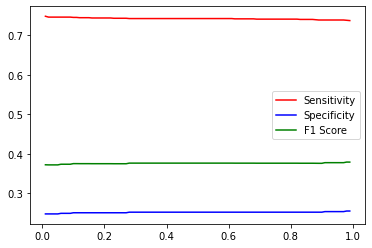

In [19]:
plt.plot(threshold, sensi, 'red')
plt.plot(threshold, speci, 'blue')
plt.plot(threshold, f1, 'green')
plt.legend(['Sensitivity', 'Specificity', 'F1 Score'])

In [20]:
test_gen = train_generator(test_data_frame, BATCH_SIZE,
                            None,
                            dict(),
                            target_size=(height, width))
pred = model.predict(test_gen, steps=len(test_data_frame) // BATCH_SIZE)

tr = 0.8

pred[pred>tr] = 1
pred[pred<=tr] = 0

pred = np.sum(pred, axis=(1,2,3))      # onno model e pred[0] er jaygay pred hobe
pred[pred>0] = 1

true = []
for i in test_data_frame['mask']:
    img = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
    s = np.sum(img)
    if s > 0:
        true.append(1)
    else:
        true.append(0)

true = np.array(true)

m = min(pred.size, true.size)
cm = metrics.confusion_matrix(true[:m], pred[:m])

TN = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
TP = cm[1][1]

# calculate the sensitivity
conf_sensitivity = (TP / float(TP + FN))    
# calculate the specificity
conf_specificity = (TN / float(TN + FP))
# calculate precision
conf_precision = (TN / float(TN + FP))
# calculate f_1 score
conf_f1 = 2 * ((conf_precision * conf_sensitivity) / (conf_precision + conf_sensitivity))

print('Sensitivity', conf_sensitivity)
print('Specificity', conf_specificity)
print('F1 score', conf_f1)

Found 2057 validated image filenames.
Found 2057 validated image filenames.
Sensitivity 0.7406593406593407
Specificity 0.2518301610541728
F1 score 0.3758636453534178


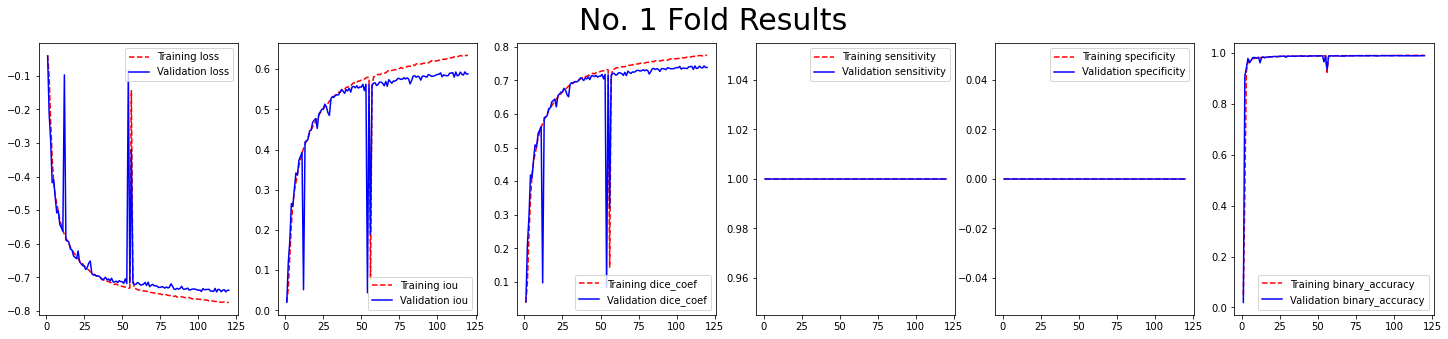

In [21]:
import pickle

for h, history in enumerate(histories):

    keys = history.history.keys()
    fig, axs = plt.subplots(1, len(keys)//2, figsize = (25, 5))
    fig.suptitle('No. ' + str(h+1) + ' Fold Results', fontsize=30)

    for k, key in enumerate(list(keys)[:len(keys)//2]):
        training = history.history[key]
        validation = history.history['val_' + key]

        epoch_count = range(1, len(training) + 1)

        axs[k].plot(epoch_count, training, 'r--')
        axs[k].plot(epoch_count, validation, 'b-')
        axs[k].legend(['Training ' + key, 'Validation ' + key])
            
    with open(str(h+1) + '_nuclei_trainHistoryDict', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

In [22]:
print('accuracies : ', accuracies)
print('losses : ', losses)
print('dicecoefs : ', dicecoefs)
print('ious : ', ious)

print('-----------------------------------------------------------------------------')
print('-----------------------------------------------------------------------------')

print('average accuracy : ', np.mean(np.array(accuracies)))
print('average loss : ', np.mean(np.array(losses)))
print('average dicecoefs : ', np.mean(np.array(dicecoefs)))
print('average ious : ', np.mean(np.array(ious)))
print()

print('standard deviation of accuracy : ', np.std(np.array(accuracies)))
print('standard deviation of loss : ', np.std(np.array(losses)))
print('standard deviation of dicecoefs : ', np.std(np.array(dicecoefs)))
print('standard deviation of ious : ', np.std(np.array(ious)))

accuracies :  [0.9899543523788452]
losses :  [-0.742493748664856]
dicecoefs :  [0.742493748664856]
ious :  [0.5921035408973694]
-----------------------------------------------------------------------------
-----------------------------------------------------------------------------
average accuracy :  0.9899543523788452
average loss :  -0.742493748664856
average dicecoefs :  0.742493748664856
average ious :  0.5921035408973694

standard deviation of accuracy :  0.0
standard deviation of loss :  0.0
standard deviation of dicecoefs :  0.0
standard deviation of ious :  0.0


In [23]:
selector = np.argmin(abs(np.array(ious) - np.mean(ious)))
model = load_model(str(selector+1) + '_unet_ner_seg.hdf5', custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef, 'sensitivity': sensitivity, 'specificity': specificity})

1 15


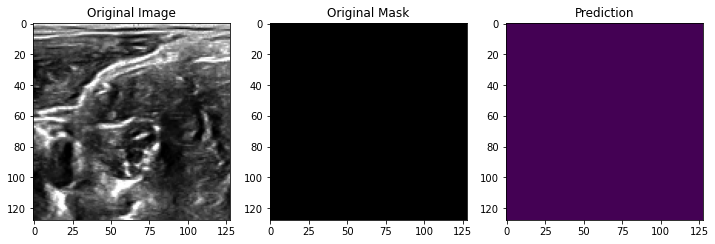

2 1822


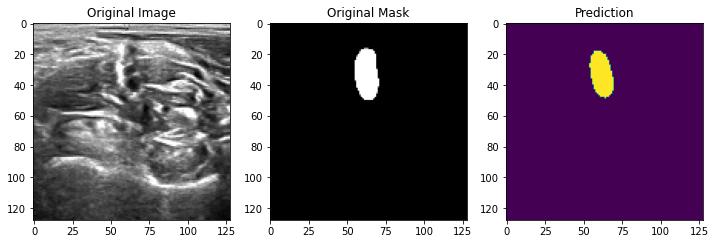

3 286


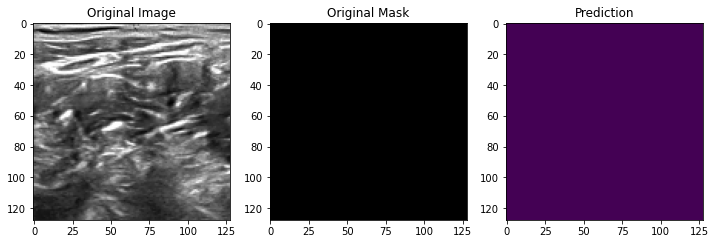

4 1953


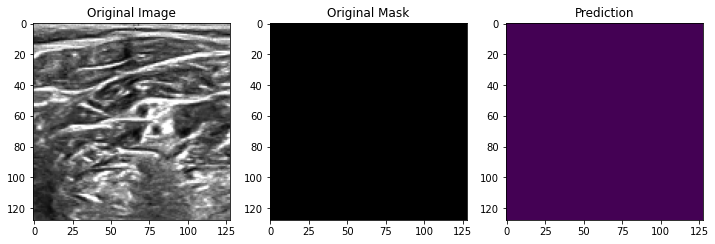

5 1821


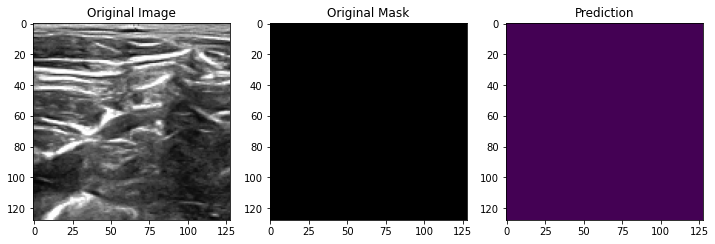

6 894


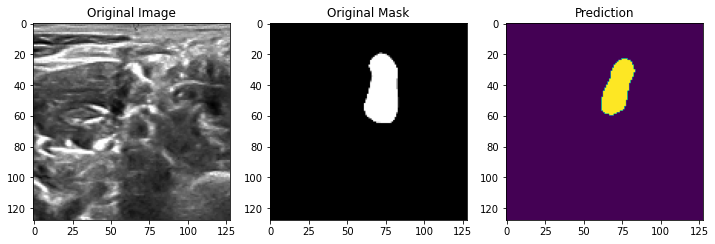

7 475


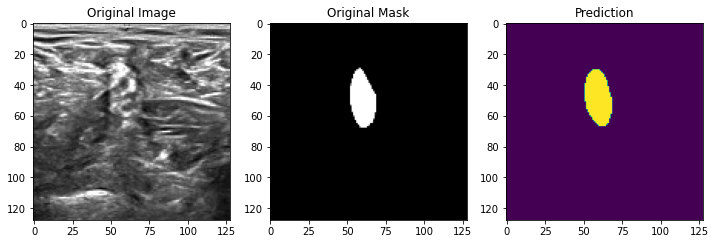

8 1659


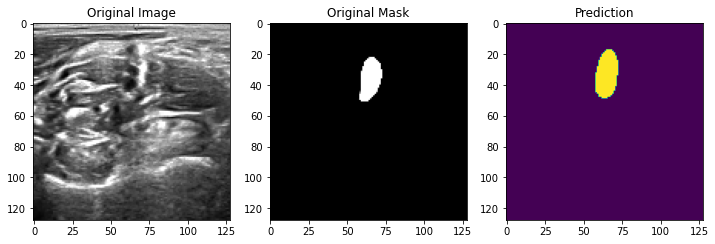

9 883


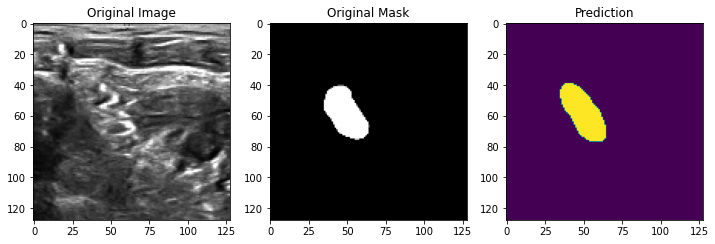

10 1377


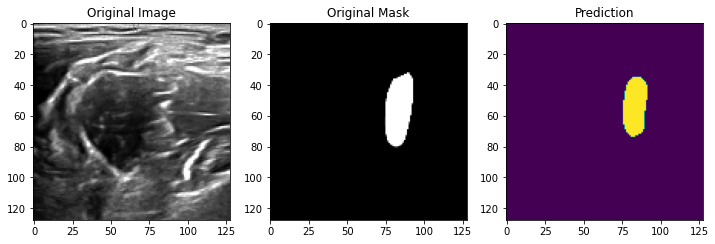

11 71


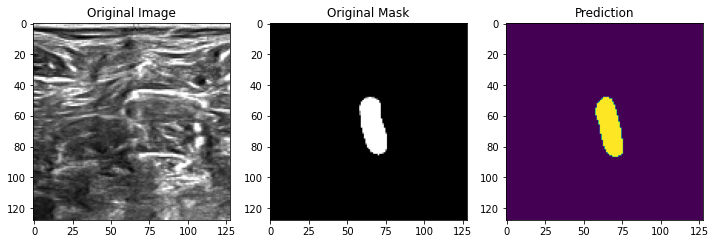

12 1271


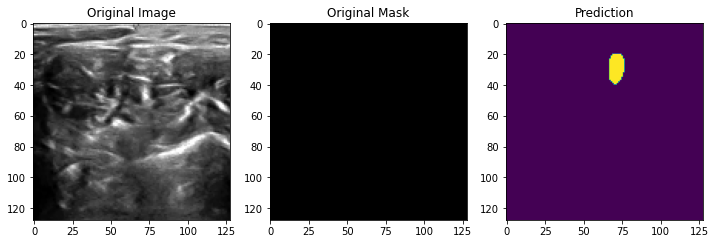

13 194


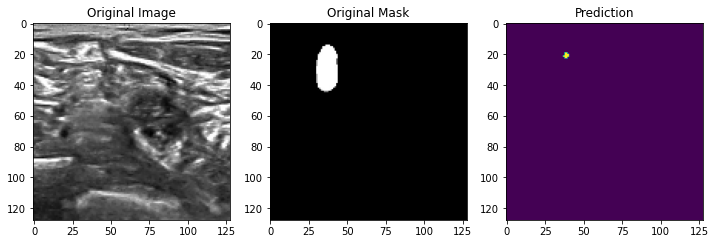

14 1845


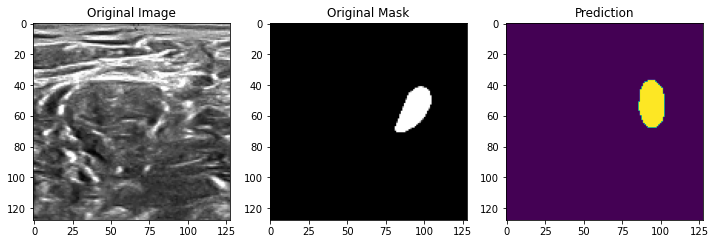

15 1576


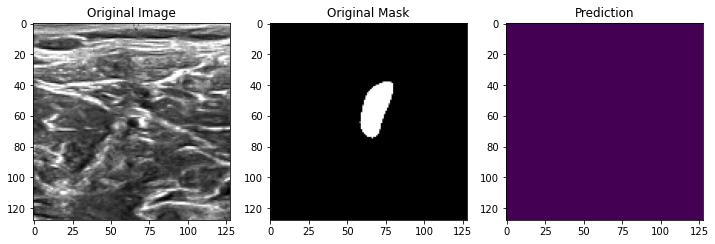

16 1403


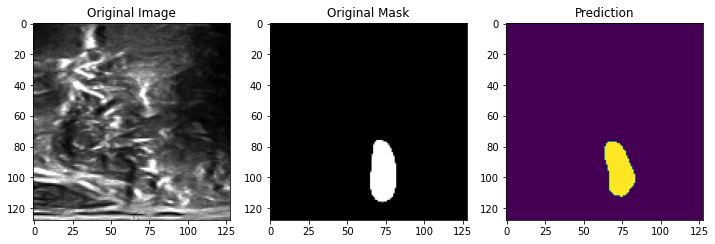

17 914


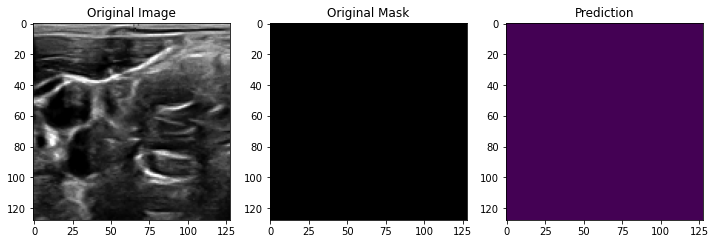

18 340


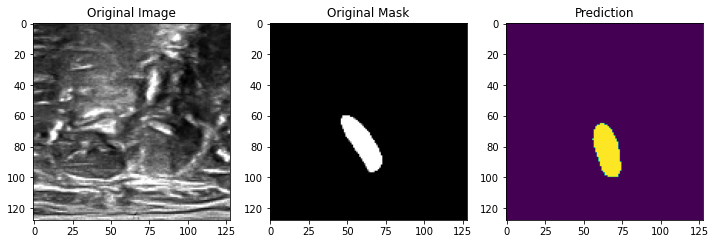

19 962


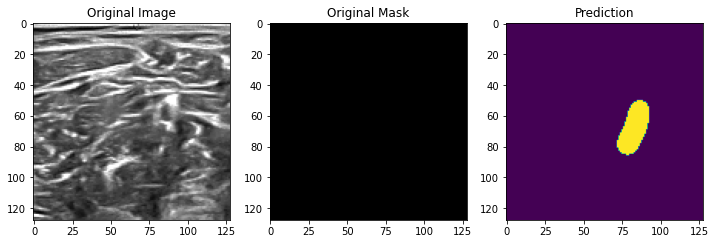

20 1965


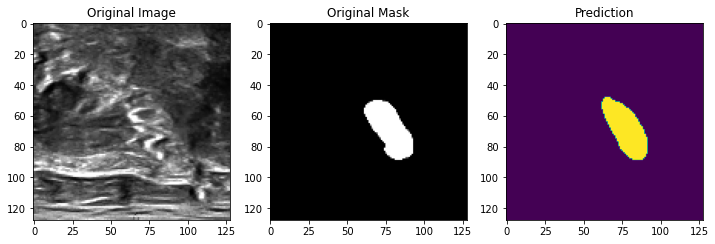

In [24]:
for i in range(20):
    index=np.random.randint(0,len(test_data_frame.index))
    print(i+1, index)
    img = cv2.imread(test_data_frame['filename'].iloc[index])
    img = cv2.resize(img, (height, width))
    img = img[np.newaxis, :, :, :]
    img = img / 255
    pred = model.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(cv2.resize(cv2.imread(test_data_frame['mask'].iloc[index]), (height, width))))
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred) > .5)
    plt.title('Prediction')
    plt.show()

In [25]:
!rm -r generated                                                                          